In [536]:
import numpy as np
import importlib
import matplotlib as mpl
import matplotlib.pylab as plt
import time
from copy import deepcopy
import torch
import IPython.display as IPd

from stg_energy.common import col, svg, samples_nd, get_labels_8pt
from stg_energy.fig5_cc.viz import vis_sample_plain
from pyloric.sbi_prior import create_prior, create_prior_general
from pyloric.sbi_wrapper import simulate, simulate_general, load_setup, get_time, stats
from stg_energy.fig7_temp.process_samples import merge_samples
import stg_energy.fig7_temp.viz

from stg_energy.fig2_histograms.energy import select_ss_close_to_obs
from parameters import ParameterSet

# Fig 7: posterior over temperatures
Results are the same as in my MSc thesis. This means that they were created with delfi, and they are on a different lobster.

In [537]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [538]:
PANEL_A1 = '../svg/panel_a1.svg'
PANEL_A2 = '../svg/panel_a2.svg'

PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'

PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'
PANEL_C3 = '../svg/panel_c3.svg'

PANEL_D1 = '../svg/panel_d1.svg'
PANEL_D2 = '../svg/panel_d2.svg'

PANEL_E1 = '../svg/panel_e1.svg'
PANEL_E2 = '../svg/panel_e2.svg'
PANEL_E3 = '../svg/panel_e3.svg'
PANEL_E4 = '../svg/panel_e4.svg'

In [539]:
setups_dict = ParameterSet('/home/michael/Documents/pyloric/pyloric/setups.prm')
hyperparams_11 = setups_dict['collect_samples_15deg_46D']

prior = create_prior(log=True)
general_prior = create_prior_general(hyperparams_11, log=True)

dimensions_11 = 31
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T 
dimensions_15 = 46
lims_15 = np.asarray([-np.sqrt(3)*np.ones(dimensions_15), np.sqrt(3)*np.ones(dimensions_15)]).T

lims = torch.cat((prior.support.lower_bound.unsqueeze(0), prior.support.upper_bound.unsqueeze(0)), dim=0).T

params_mean = prior.mean.numpy()
params_std = prior.stddev.numpy()

params_mean_41 = general_prior.mean.numpy()
params_std_41 = general_prior.stddev.numpy()

### Load samples from 11 deg, 15deg, 19deg, 23deg, 27deg

In [540]:
npz = np.load("../../results/experimental_data/summstats_prep845_082_0044.npz")
observation = npz["summ_stats"]

npz = np.load("../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [541]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
sample_params_11 = data["sample_params"]
sample_stats_11 = data["sample_stats"]

In [542]:
data = np.load(f"../../results/temperature/sbi/201005_5Million_post_pred_close_to_obs_simulated_at_27_and_robust_Q10s_from_1point3_to_2point3.npz")
sample_params_27 = data['params']
sample_stats_27 = data['stats_11']
stats_27_at_27 = data['stats_27']
seeds_27 = data['seeds_27']

### Filter the remaining samples

In [483]:
min_freq_at_27 = 1/observation[0]*1000 * 1.7**(16/10)
print('Frequency at 27 should be at least:  ', min_freq_at_27)
max_dur_at_27 = 1/min_freq_at_27*1000

Frequency at 27 should be at least:   1.9962449308494963


In [484]:
sample_params_27 = sample_params_27[stats_27_at_27[:,0] < max_dur_at_27]
sample_stats_27 = sample_stats_27[stats_27_at_27[:,0] < max_dur_at_27]
seeds_27 = seeds_27[stats_27_at_27[:,0] < max_dur_at_27]
stats_27_at_27 = stats_27_at_27[stats_27_at_27[:,0] < max_dur_at_27]

Enforce constant phase

In [485]:
condition1 = stats_27_at_27[:,13] > observation[13]-0.1
condition2 = stats_27_at_27[:,13] < observation[13]+0.1
condition3 = stats_27_at_27[:,14] > observation[14]-0.1
condition4 = stats_27_at_27[:,14] < observation[14]+0.1
all_conditions = np.logical_and(np.logical_and(np.logical_and(condition1, condition2), condition3), condition4)
sample_params_27 = sample_params_27[all_conditions]
sample_stats_27 = sample_stats_27[all_conditions]
seeds_27 = seeds_27[all_conditions]
stats_27_at_27 = stats_27_at_27[all_conditions]

In [543]:
sample_stats_11 = sample_stats_11[:sample_stats_27.shape[0]]
sample_params_11 = sample_params_11[:sample_stats_27.shape[0]]
print(sample_params_11.shape)

(5080, 31)


In [544]:
sample_stats_27.shape

(5080, 46)

In [545]:
# sample_stats_27 = sample_stats_27[:all_stats_fast_enough.shape[0]]
# sample_stats_11 = sample_stats_11[:all_stats_fast_enough.shape[0]]

In [546]:
datafile = "../../results/prior_samples_after_classifier/samples_full_3.npz"
data = np.load(datafile)
stats_prior = data["stats"]
stats_mean = np.mean(stats_prior, axis=0)
stats_std = np.std(stats_prior, axis=0)

In [547]:
dists_11 = np.abs(sample_stats_11[:,:18] - observation)
dists_27 = np.abs(sample_stats_27[:,:18] - observation)

# Plot posteriors

In [514]:
from decimal import Decimal
all_labels = []
for dim_i in range(41):
    if dim_i >= 31:
        all_labels.append([r'$\mathdefault{1.0}$ ', r'$\mathdefault{2.0}\;\;\;\;$  '])
    elif dim_i >= 24: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$ ', r'$\mathdefault{10000}\;\;\;\;$  '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}$', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims_15[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims_15[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$ ')
            counter+=1
        all_labels.append(new_labels)

labels_ = get_labels_8pt()
labels_[9] += ''

/home/michael/Documents/STG_energy/stg_energy/common.py:625: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


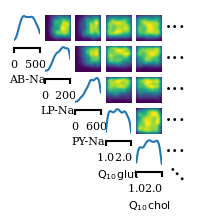

In [515]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    q10_samples = general_prior.sample((sample_params_11.shape[0],))[:, -15:]
    sample_params_11_q10 = np.concatenate((sample_params_11, q10_samples), axis=1)
    sample_params_11_norm = (sample_params_11_q10 - params_mean_41) / params_std_41
    _ = samples_nd(
        samples=sample_params_11_norm[:10020],
        subset=[0,8,16,31,32],
        upper=['kde'],
        diag=['kde'],
        fig_size=(1.9, 1.9),
        limits=lims_15,
        ticks=lims_15,
        tick_labels=all_labels,
        labels=labels_,
    )
    plt.savefig(PANEL_A1, facecolor='None', transparent=True)

In [516]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    sample_params_27_norm = (sample_params_27 - params_mean_41) / params_std_41
    _ = samples_nd(
        samples=sample_params_27_norm[:10000],
        subset=[0,8,16,31,32],
        upper=['kde'],
        diag=['kde'],
        fig_size=(1.9, 1.9),
        limits=lims_15,
        ticks=lims_15,
        tick_labels=all_labels,
        labels=labels_,
    )
    plt.savefig(PANEL_A2, facecolor='None', transparent=True)

ValueError: operands could not be broadcast together with shapes (1242,31) (46,) 

### Temperature: 27deg. Check how many samples from 11deg, 15deg,..., 27deg posterior produce no NaN
This is rather just a sanity check

In [ ]:
hyperparams_11.model_params.temp = 299

In [495]:
# sims_per_dataset = 10
# num_good_in_dataset = []
# for dataset_temp in [sample_params_11, sample_params_27]:
#     print("New dataset")
#     counter_good = 0
#     for sample_ind in range(sims_per_dataset):
#         if dataset_temp.shape[1] == 31:
#             q10 = general_prior.sample((1,)).numpy()[0, -10:]
#             parameter_set = np.concatenate((dataset_temp[sample_ind].astype(np.float64), q10),)
#         else:
#             parameter_set = dataset_temp[sample_ind].astype(np.float64)
#         out_target = simulate_general(
#             deepcopy(parameter_set),
#             hyperparams_11,
#             seed=0,
#         )
#         ss = stats(out_target)
#         if np.invert(np.any(np.isnan(ss[:15]))):
#             counter_good += 1
#     num_good_in_dataset.append(counter_good)
# print("Percentage of good samples for 11 and 27 degree posteriors:", np.asarray(num_good_in_dataset)/sims_per_dataset*100)

# Plot a sample from the 27deg posterior across temperatures

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


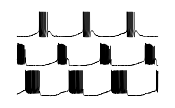

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


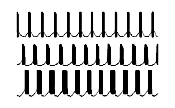

In [354]:
sample_index = 2
parameter_set = sample_params_27[sample_index].astype(np.float64)

for temp in [283, 299]:

    hyperparams_11.model_params.temp = temp

    out_target = simulate_general(
        deepcopy(parameter_set),
        hyperparams_11,
        seed=0,
    )

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(2.0, 1.15))
        fig = vis_sample_plain(
            out_target,
            get_time(),
            ax,
            time_len=150000,
            col='k',
            scale_bar=False,
        )
        if temp == 283:
            plt.savefig(PANEL_B1, facecolor='None', transparent=True)
        elif temp == 299:
            plt.savefig(PANEL_B2, facecolor='None', transparent=True)
        plt.show()

# Show speed-up

### Simulate 5 parameter sets at every temperature from 11 to 27 degree

In [355]:
data = np.load(f"../../results/temperature/sbi/201005_5Million_post_pred_close_to_obs_simulated_at_27_and_robust_Q10s_from_1point3_to_2point3.npz")
all_sample_params_27 = data['params']
all_sample_stats_27 = data['stats_11']
all_stats_27_at_27 = data['stats_27']
all_seeds_27 = data['seeds_27']

In [356]:
all_durs_each_set = []
all_stats_each_set = []
skip_steps = 1
for counter, param_set in enumerate(all_sample_params_27[:5]):
    print("New parameter set, ", counter)
    all_cycle_durs = []
    all_stats = []
    for temp in range(283, 300, skip_steps):

        hyperparams_11.model_params.temp = temp

        out_target = simulate_general(
            deepcopy(param_set.astype(np.float64)),
            hyperparams_11,
            seed=0,
        )

        summstats = stats(out_target)
        all_cycle_durs.append(summstats[0])
        all_stats.append(summstats[:18])
    all_durs_each_set.append(all_cycle_durs)
    all_stats_each_set.append(all_stats)
all_durs_each_set = np.asarray(all_durs_each_set)
all_stats_each_set = np.asarray(all_stats_each_set)

New parameter set,  0


/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: 

In [ ]:
all_durs_each_set.shape

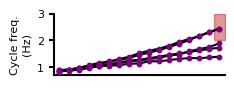

In [305]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.2, 0.8))
    ax.fill_between([298.5, 299.5], 2., 2.99, alpha=0.4, color='#b30000', edgecolor='#b30000')
    xaxis = np.arange(283, 300, skip_steps)
    for traces in all_durs_each_set:
        ax.plot(xaxis, 1./traces*1000, 'k')
    for traces in all_durs_each_set:
        ax.scatter(xaxis, 1./traces*1000, s=10, c='purple', zorder=1000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([282.5, 299.5])
    ax.set_xticks([283, 287, 291, 295, 299])
#     ax.set_xlabel("Temperature (°C)")
    ax.set_xticks([])
    ax.set_ylabel("Cycle freq.\n(Hz)")
    ax.set_ylim([0.70, 3])
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

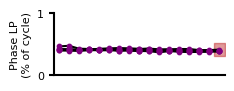

In [306]:
phase_LP = all_stats_each_set[:, :, 13]
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.2, 0.8))
    xaxis = np.arange(283, 300, skip_steps)
    ax.fill_between([298.5, 299.5], (observation[13]-0.1), (observation[13]+0.1), alpha=0.4, color='#b30000', edgecolor='#b30000')
    for traces in phase_LP:
        ax.plot(xaxis, traces, 'k')
    for traces in phase_LP:
        ax.scatter(xaxis, traces, s=10, c='purple', zorder=1000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([282.5, 299.5])
    ax.set_xticks([283, 287, 291, 295, 299])
#     ax.set_xlabel("Temperature (°C)")
    ax.set_xticks([])
    ax.set_ylabel("Phase LP\n(% of cycle)")
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

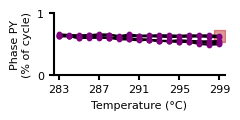

In [307]:
phase_PY = all_stats_each_set[:, :, 14]
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.2, 0.8))
    xaxis = np.arange(283, 300, skip_steps)
    ax.fill_between([298.5, 299.5], (observation[14]-0.1), (observation[14]+0.1), alpha=0.4, color='#b30000', edgecolor='#b30000')
    for traces in phase_PY:
        ax.plot(xaxis, traces, 'k')
    for traces in phase_PY:
        ax.scatter(xaxis, traces, s=10, c='purple', zorder=1000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([282.5, 299.5])
    ax.set_xticks([283, 287, 291, 295, 299])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Phase PY\n(% of cycle)")
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    plt.savefig(PANEL_C3, facecolor='None', transparent=True)
    plt.show()

# Relation between energy efficiency and temperature robustness

### Load samples from 27deg posterior. Samples have been rejected if too far from obs at 11deg and then been simulated at 27deg

In [357]:
all_energies_per_spike_11 = sample_stats_11[:, 18:21]
num_spikes_11 = sample_stats_11[:, 24:27]
all_total_energies_11 = sample_stats_11[:, 21:24]

all_energies_per_spike_27 = sample_stats_27[:, 19:22]
num_spikes_27 = sample_stats_27[:, 31:34]
all_total_energies_27 = sample_stats_27[:, 28:31]

In [358]:
summed_energies_per_spike_11 = np.asarray(all_energies_per_spike_11)[:, 0] # look at AB/PD
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1)

summed_energies_per_spike_27 = np.asarray(all_energies_per_spike_27)[:, 0] # look at AB/PD
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1)

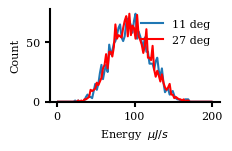

In [427]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.2))

    hist_vals_11 = ax.hist(summed_energies_total_11/40000, range=(0, 200), bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27/40000, range=(0, 200), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0])
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='r')
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy  $\mu J/s$')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend((line11[0], line27[0]), ('11 deg', '27 deg'))

    plt.savefig(PANEL_D1, facecolor='None', transparent=True)

# Some new analysis

### AB/PD neuron

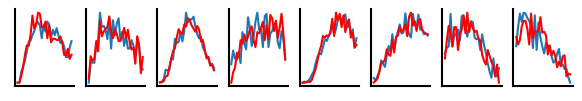

In [440]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 8, figsize=(7.2, 1.))
    param_counter = 0
    for a in ax:
        hist_vals_11 = np.histogram(sample_params_11_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        hist_vals_27 = np.histogram(sample_params_27_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        a.plot(hist_vals_11[0])
        a.plot(hist_vals_27[0], c='r')
        a.set_yticks([])
        a.set_xticks([])
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        param_counter += 1
    plt.savefig(PANEL_E1, facecolor='None', transparent=True)

### LP neuron

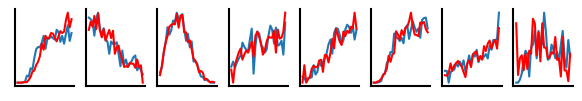

In [441]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 8, figsize=(7.2, 1.))
    param_counter = 8
    for a in ax:
        hist_vals_11 = np.histogram(sample_params_11_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        hist_vals_27 = np.histogram(sample_params_27_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        a.plot(hist_vals_11[0])
        a.plot(hist_vals_27[0], c='r')
        a.set_yticks([])
        a.set_xticks([])
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        param_counter += 1
    plt.savefig(PANEL_E2, facecolor='None', transparent=True)

### PY neuron

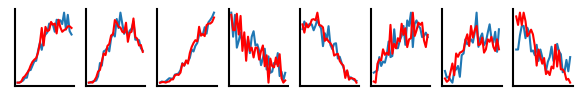

In [442]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 8, figsize=(7.2, 1.))
    param_counter = 16
    for a in ax:
        hist_vals_11 = np.histogram(sample_params_11_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        hist_vals_27 = np.histogram(sample_params_27_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        a.plot(hist_vals_11[0])
        a.plot(hist_vals_27[0], c='r')
        a.set_yticks([])
        a.set_xticks([])
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        param_counter += 1
    plt.savefig(PANEL_E3, facecolor='None', transparent=True)

### Synapses

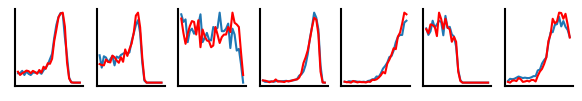

In [443]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 7, figsize=(7.2, 1.))
    param_counter = 24
    for a in ax:
        hist_vals_11 = np.histogram(sample_params_11_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        hist_vals_27 = np.histogram(sample_params_27_norm[:, param_counter], range=[-1.73, 1.73], bins=30)
        a.plot(hist_vals_11[0])
        a.plot(hist_vals_27[0], c='r')
        a.set_yticks([])
        a.set_xticks([])
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        param_counter += 1
    plt.savefig(PANEL_E4, facecolor='None', transparent=True)

# Analyse energy consumption at 27 degree

In [548]:
stats_27_at_27[0]

array([ 3.45482143e+02,  5.40206897e+01,  7.16655172e+01,  8.99344828e+01,
        8.10089286e+01,  4.39303571e+01,  1.35071429e+02,  2.50763393e+02,
        1.56363189e-01,  2.07436242e-01,  2.60315865e-01,  2.34480798e-01,
        1.27156665e-01,  3.90965007e-01,  7.25836047e-01,  2.50000000e+00,
        2.50000000e+00,  2.50000000e+00,  1.00000000e+00,  2.06199848e+03,
        1.22879474e+03,  5.45216691e+03,  2.90000000e+01,  2.90000000e+01,
        2.90000000e+01,  2.38196376e+04,  1.36438588e+04,  9.81390044e+04,
        6.97450740e+05,  4.04616456e+05,  2.86130175e+06,  3.35000000e+02,
        3.22000000e+02,  5.22000000e+02, -5.92486511e+01, -5.80999160e+01,
       -6.05699555e+01,  1.33715058e+01,  1.36715456e+01,  2.00422333e+01,
        2.99034095e+00,  1.91946998e+00,  2.49567894e+00,  1.46874072e+01,
        6.81421983e+00,  9.17177216e+00])

In [549]:
total_energy_at_27 = np.sum(stats_27_at_27[:, 28:31], axis=1)
print(total_energy_at_27.shape)

(5080,)


In [550]:
total_energy_at_11 = np.sum(sample_stats_27[:, 28:31], axis=1)
print(total_energy_at_11.shape)

(5080,)


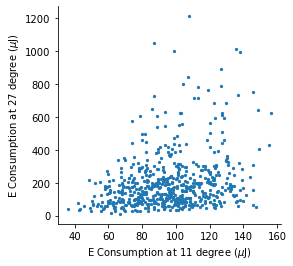

In [553]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
num_scatter = 600
ax.scatter(total_energy_at_11[:num_scatter]/40000, total_energy_at_27[:num_scatter]/40000, s=5)
# ax.plot([1e6, 6e6], [1e6, 6e6], 'r')
ax.set_xlabel("E Consumption at 11 degree ($\mu$J)")
ax.set_ylabel("E Consumption at 27 degree ($\mu$J)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./temp_fig2.png', dpi=300)

# Compose figure

In [444]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [448]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "17.0cm",

    Panel(
          SVG(PANEL_A1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_A2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(33*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(68*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(68*factor_svg, 18*factor_svg),

    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", -1.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(100*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(100*factor_svg, 13*factor_svg),

    Panel(
          SVG(PANEL_C3).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(100*factor_svg, 26*factor_svg),

    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("d", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 49*factor_svg),

    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 66*factor_svg),

    Panel(
          SVG(PANEL_E3).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 83*factor_svg),

    Panel(
          SVG(PANEL_E4).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 100*factor_svg),
           
    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("e", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(100.5*factor_svg, 50*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig7.svg")
svg('../fig/fig7.svg')